In [1]:
%matplotlib inline
from sklearn.svm import LinearSVC 
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick

In [2]:
def split_test_validation(filename):
    raw_terms = pickle.load(open(filename,'rb')).drop(['TERM_VECTOR'], axis=1)
    terms = raw_terms[raw_terms['OCCURENCES']>2]
    terms.drop(['NGRAM','OCCURENCES'], axis=1, inplace=True)
    bterm = terms[terms['BUSINESS']==1]['TERM']
    clean_term = terms[~((terms['BUSINESS']==0) & (terms['TERM'].isin(bterm)))]
    
    print(clean_term.shape)
    term_count = clean_term.groupby('TERM')['TERM'].count()
    print(term_count[term_count>1])
    print(clean_term.groupby('BUSINESS')['BUSINESS'].count())
    
    business_terms = clean_term[clean_term['BUSINESS']==1]
    nonbusiness_terms = clean_term[clean_term['BUSINESS']==0]
    
    business_train, business_test_validation = train_test_split(business_terms, test_size = 0.3)
    business_test, business_validation = train_test_split(business_test_validation, test_size = 1/3)
    nonbusiness_train, nonbusiness_test_validation = train_test_split(nonbusiness_terms, test_size = 0.3)
    nonbusiness_test, nonbusiness_validation = train_test_split(nonbusiness_test_validation, test_size = 1/3)
    del business_test_validation
    del nonbusiness_test_validation
    
    nonbusiness_train = nonbusiness_train.sample(n=len(business_train))
    nonbusiness_validation = nonbusiness_validation.sample(n=len(business_validation))
    nonbusiness_test = nonbusiness_test.sample(n=len(business_test))

    train_labels = pd.concat([business_train,nonbusiness_train]).drop(['BUSINESS'],axis=1)
    train_labels['SET'] = 'TRAIN'
    validation_labels = pd.concat([business_validation,nonbusiness_validation]).drop(['BUSINESS'],axis=1)
    validation_labels['SET'] = 'VALIDATION'
    test_labels = pd.concat([business_test,nonbusiness_test]).drop(['BUSINESS'],axis=1)
    test_labels['SET'] = 'TEST'
    
    train_validation_test = pd.concat([train_labels, validation_labels, test_labels])
    
    return train_validation_test

def create_features_labels(filename, vectortype, train_validation_test):
    raw_terms = pickle.load(open(filename,'rb')).rename(columns={'TERM_VECTOR':'FEATURE_VECTOR'})
    if vectortype == 'tfidf':
        terms_count = raw_terms.groupby('TERM')['TERM'].count()
        terms =  raw_terms[raw_terms['TERM'].map(terms_count)>2]
        #terms['FEATURE_VECTOR'] = terms.apply(lambda x: [x['TERM_VECTOR{}'.format(y)] for y in range(0,10)],axis=1)
        terms.drop(['NGRAM','ROWNUM'], axis=1, inplace=True)
    else:
        terms = raw_terms[raw_terms['OCCURENCES']>2]
        #terms['FEATURE_VECTOR'] = terms.apply(lambda x: [x['TERM_VECTOR{}'.format(y)] for y in range(0,10)],axis=1)
        #terms.drop(['TERM_VECTOR{}'.format(y) for y in range(0,10)]+['NGRAM','ROWNUM','TERMTYPE'], axis=1, inplace=True)
        terms.drop(['NGRAM','OCCURENCES'], axis=1, inplace=True)
    
    bterm = terms[terms['BUSINESS']==1]['TERM']
    terms = terms[~((terms['BUSINESS']==0) & (terms['TERM'].isin(bterm)))]
    
    terms = terms.merge(train_validation_test, 'left', 'TERM')
    
    terms_count = terms.groupby('TERM')['TERM'].count()
    
    train_dataset =  terms[terms['SET']=='TRAIN'].drop(['SET'],axis=1)
    validation_dataset =  terms[terms['SET']=='VALIDATION'].drop(['SET'],axis=1)
    test_dataset =  terms[terms['SET']=='TEST'].drop(['SET'],axis=1)

    
    train_dataset = train_dataset.iloc[np.random.permutation(len(train_dataset))]
    validation_dataset = validation_dataset.iloc[np.random.permutation(len(validation_dataset))]
    test_dataset = test_dataset.iloc[np.random.permutation(len(test_dataset))]
    
    print("Train-")
    print(train_dataset.groupby('BUSINESS')['BUSINESS'].count())
    print("Validation-")
    print(validation_dataset.groupby('BUSINESS')['BUSINESS'].count())
    print("Test-")
    print(test_dataset.groupby('BUSINESS')['BUSINESS'].count())
    
    train_features = np.vstack(train_dataset['FEATURE_VECTOR'].map(lambda x : np.array([0.000001 if y==0 else y for y in x]) ).values)
    train_labels = np.vstack(train_dataset['BUSINESS'].values)
    validation_features = np.vstack(validation_dataset['FEATURE_VECTOR'].map(lambda x : np.array([0.000001 if y==0 else y for y in x]) ).values)
    validation_labels = np.vstack(validation_dataset['BUSINESS'].values)
    test_features = np.vstack(test_dataset['FEATURE_VECTOR'].map(lambda x : np.array([0.000001 if y==0 else y for y in x]) ).values)
    test_labels = np.vstack(test_dataset['BUSINESS'].values)
    
    return train_features, train_labels, validation_features, validation_labels,  test_features, test_labels


In [101]:
pickle.load(open('ngram_10krows_ml_kn.pickle','rb'))

,TERM,OCCURENCES,NGRAM,BUSINESS,TERM_VECTOR
0,'SOMENUM SOMENUM,2,2,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
1,'SOMENUM SOMENUM people,2,3,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
2,'SOMENUM SOMENUM people died,2,4,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
3,'SOMENUM SOMENUM people died today,2,5,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
4,'SOMENUM SOMENUM people died today in,2,6,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
5,'SOMENUM SOMENUM people died today in suicide,2,7,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
6,'SOMENUM SOMENUM people died today in suicide ...,2,8,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
7,'SOMENUM SOMENUM people died today in suicide ...,2,9,0,"[7.423522001309227e-05, 0.002786358544140904, ..."
8,'SOMENUM SOMENUM.SOMENUM,2,2,0,"[7.423522001309227e-05, 0.014364019961893643, ..."
9,'SOMENUM SOMENUM.SOMENUM SOMENUM.SOMENUM,2,3,0,"[7.423522001309227e-05, 0.014364019961893643, ..."


In [3]:
train_validation_test = split_test_validation('ngram_10krows_ml_kn.pickle')
train_features, train_labels, validation_features, validation_labels,  test_features, test_labels = \
create_features_labels('ngram_10krows_tfidf.pickle', 'tfidf', train_validation_test)
clf = LinearSVC()
clf.fit(train_features, train_labels.ravel())
clf.score(test_features, test_labels.ravel())

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(362687, 2)
Series([], Name: TERM, dtype: int64)
BUSINESS
0    323237
1     39450
Name: BUSINESS, dtype: int64


/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train-
BUSINESS
0    150678
1    194038
Name: BUSINESS, dtype: int64
Validation-
BUSINESS
0    21495
1    27143
Name: BUSINESS, dtype: int64
Test-
BUSINESS
0    43421
1    55771
Name: BUSINESS, dtype: int64


0.62978869263650294

In [4]:
train_features, train_labels, validation_features, validation_labels,  test_features, test_labels = \
create_features_labels('ngram_10krows_word2vec_05_threshold.pickle', 'word2vec', train_validation_test)
clf = LinearSVC()
clf.fit(train_features, train_labels.ravel())
clf.score(test_features, test_labels.ravel())

Train-
BUSINESS
0    27615
1    27615
Name: BUSINESS, dtype: int64
Validation-
BUSINESS
0    3945
1    3945
Name: BUSINESS, dtype: int64
Test-
BUSINESS
0    7890
1    7890
Name: BUSINESS, dtype: int64


0.81001267427122936

In [ ]:
train_features, train_labels, validation_features, validation_labels,  test_features, test_labels = \
create_features_labels('ngram_10krows_ml_kn.pickle', 'ml', train_validation_test)
clf = LinearSVC()
clf.fit(train_features, train_labels.ravel())
clf.score(test_features, test_labels.ravel())

In [26]:
def plot_performance(title, performance):
    f, ax = plt.subplots(1, figsize=(6,3))
    objects = ('1', '2', '3', '4')
    y_pos = np.arange(len(objects))
    rects = ax.bar(y_pos, performance, align='center', alpha=0.5)
    plt.ylabel('Accuracy %')
    plt.xlabel('Number of Hidden Layers')
    plt.ylim([0,1])
    plt.xticks(y_pos, objects)
    plt.title(title)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{:3.2f}%'.format(height*100),
                ha='center', va='bottom')

    plt.show()

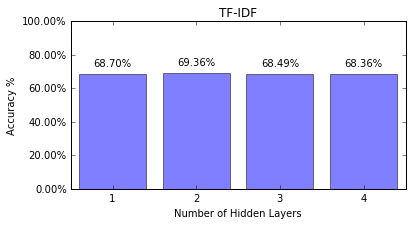

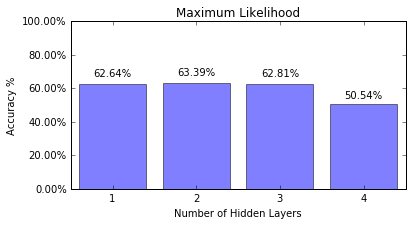

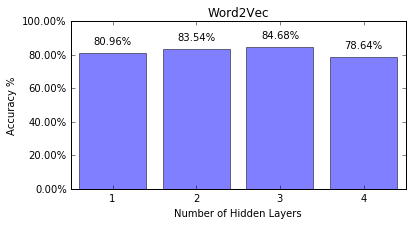

In [27]:
performance_dict = {
    'Maximum Likelihood': [0.626425855513308, 0.6339036755386566, 0.6280735107731306,0.5054499366286439],
    'TF-IDF': [0.6869772748683701, 0.6936451278615766, 0.6848523546837219,0.6835753090555096],
    'Word2Vec':[0.8095690747782003, 0.835361216730038, 0.8468314321926489, 0.7863751584283903]
}
for i,val in performance_dict.items():
    plot_performance(i, val)

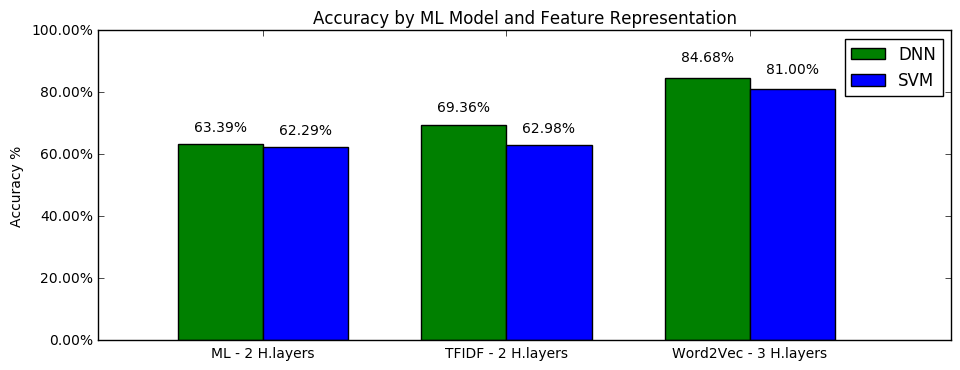

In [11]:
N = 3
DNN_Accuracy = (0.6339036755386566, 0.6936451278615766, 0.8468314321926489)
SVM_Accuracy = (0.62294043092522178, 0.62978869263650294, 0.81001267427122936)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(1, figsize=(11,4))
rects1 = ax.bar(ind, DNN_Accuracy, width, align='center', color='g')
rects2 = ax.bar(ind + width, SVM_Accuracy, width, align='center', color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy %')
ax.set_title('Accuracy by ML Model and Feature Representation')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(('ML - 2 H.layers', 'TFIDF - 2 H.layers', 'Word2Vec - 3 H.layers'))

ax.legend((rects1[0], rects2[0]), ('DNN', 'SVM'))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*200) for x in vals])

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{:3.2f}%'.format(height*100),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.ylim([0,1])
plt.show()

In [ ]:
def plot_performance(title, performance):
    f, ax = plt.subplots(1, figsize=(6,3))
    objects = ('1', '2', '3', '4')
    y_pos = np.arange(len(objects))
    rects = ax.bar(y_pos, performance, align='center', alpha=0.5)
    plt.ylabel('Accuracy %')
    plt.xlabel('Number of Hidden Layers')
    plt.ylim([0,1])
    plt.xticks(y_pos, objects)
    plt.title(title)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{:3.2f}%'.format(height*100),
                ha='center', va='bottom')

    plt.show()

In [7]:
for i in [3,4,5,6,7,8,9]:
    raw_terms = pickle.load(open('ngram_10krows_word2vec_0{}_threshold.pickle'.format(i),'rb')).drop(['TERM_VECTOR'], axis=1)
    print(i, sum(raw_terms['BUSINESS'] == 1))

3 88713
4 52569
5 39450
6 12762
7 4648
8 3089
9 2675


In [ ]:
fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)

s1 = np.exp(t)
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('exp', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
s2 = np.sin(2*np.pi*t)
ax2.plot(t, s2, 'r.')
ax2.set_ylabel('sin', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
    
plt.show()

In [ ]:
plt.legend

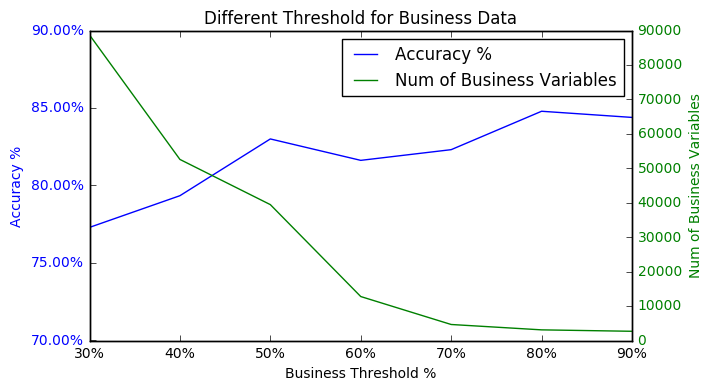

In [2]:
f, ax = plt.subplots(1, figsize=(7,4))
#f.subplots_adjust(bottom=0.2)
objects = ('30%', '40%', '50%', '60%', '70%', '80%', '90%')
y_pos = np.arange(len(objects))
ys = [0.7729680982978244, 0.7934182994103101, 0.8300380228136882, 0.8162225705329154, 0.8231182795698925, 0.8478964401294499, 0.8439252336448598]
line1 = ax.plot(y_pos, ys)
#rects = ax.bar(y_pos, performance, align='center', alpha=0.5)
ax.set_ylabel('Accuracy %', color='b')
ax.set_xlabel('Business Threshold %')
ax.set_ylim([0.7,0.9])
ax.set_xlim([-1,7])
plt.xticks(y_pos, objects)

ax.set_title('Different Threshold for Business Data')
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in y_vals])

for tl in ax.get_yticklabels():
    tl.set_color('b')

#for i,j in zip(y_pos, ys):
#    ax.annotate('{:3.2f}%'.format(j*100), xy=(i,j), xytext=(-5,10), textcoords='offset points')


ax2 = ax.twinx()
s2 = (88713,52569,39450,12762,4648,3089,2675)
line2 = ax2.plot(y_pos, s2, 'g-')
ax2.set_ylabel('Num of Business Variables', color='g')
for tl in ax2.get_yticklabels():
    tl.set_color('g')
    
plt.legend((line1[0], line2[0]), ('Accuracy %', 'Num of Business Variables'))
plt.show()

In [55]:
ax.get_xticklines()

<a list of 14 Text xtickline objects>

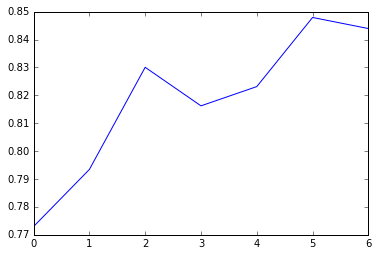

In [ ]:
type(ax)

In [ ]:
plt.ylabel

In [ ]:
plt.bar()

In [ ]:
plt.plot([1,2,3,4])
plt.ylabel('some numbers')
plt.show()